# EWB paper figure 1: showing all the cases

We provide the exact code used to generate each figure in order to be completely reproducible and to encourage others to use EWB with their own models quickly. 

In [1]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import yaml
import urllib.request
import matplotlib.font_manager
flist = matplotlib.font_manager.get_font_names()
from tempfile import NamedTemporaryFile
import urllib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patches as patches
from extremeweatherbench import evaluate, events, config
sns.set_theme(style='whitegrid')

In [2]:
# The model is irrelevant for this plot since we are just plotting the cases but we need it to grab the data
model = 'FOUR_v200_GFS'

# grab all of our event types
event_list = [events.HeatWave,
              events.Freeze,]
configuration = config.Config(
    event_types=event_list,
    )
default_forecast_config = config.ForecastSchemaConfig()
cases = evaluate.get_case_metadata(eval_config=configuration)

In [ ]:
import dataclasses

@dataclasses.dataclass
class SevereConvection(events.EventContainer):
    """A container class to hold a list of cases of severe convection events."""

    event_type: str = "severe_convection"

@dataclasses.dataclass
class AtmosphericRiver(events.EventContainer):
    """A container class to hold a list of cases of heat wave events."""

    event_type: str = "atmospheric_river"

@dataclasses.dataclass
class TropicalCyclone(events.EventContainer):
    """A container class to hold a list of cases of freeze events."""

    event_type: str = "tropical_cyclone"


full_event_list = [events.HeatWave,
              events.Freeze,
              SevereConvection,
              AtmosphericRiver,
              TropicalCyclone,
              ]

full_configuration = config.Config(
    event_types=full_event_list,
    )
cases = evaluate.get_case_metadata(eval_config=full_configuration)

In [9]:
for event in cases:
    for indiv_case in event.cases:
        print(indiv_case.location.geopandas)

290


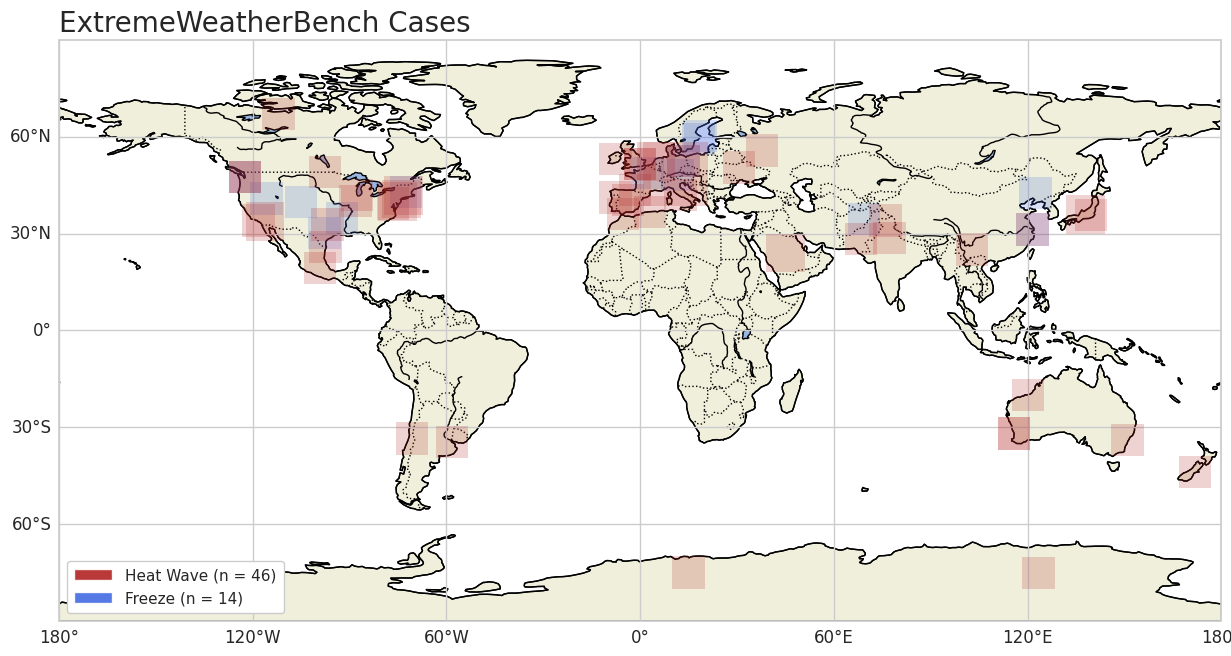

In [3]:
# plot all cases on one giant world map
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

# Add gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Define colors for each event type
event_colors = {
    'severe_day': 'darkslategray',
    'heat_wave': 'firebrick',
    'freeze': 'royalblue',
    
}

# Initialize counts for each event type
counts_by_type = dict({'freeze': 0, 'heat_wave': 0})

# Plot boxes for each case
for event in cases[::-1]:
    for indiv_case in event.cases:
        lat = indiv_case.location.latitude
        lon = indiv_case.location.longitude
        half_box = indiv_case.bounding_box_degrees
        
        # Get color based on event type
        event_type = indiv_case.event_type
        color = event_colors.get(event_type, 'gray')  # Default to gray if event type not found

        # count the events by type
        counts_by_type[event_type] += 1

        # Create a rectangle around the indiv_case location
        rect = patches.Rectangle((lon - half_box, lat - half_box), 2 * half_box, 2 * half_box,
                                linewidth=0, edgecolor=color, facecolor=color, transform=ccrs.PlateCarree(), zorder=10, alpha=0.2)
        ax.add_artist(rect)

# Create a custom legend for event types
from matplotlib.patches import Patch
legend_elements = [
    #Patch(facecolor=event_colors['severe_day'], alpha=0.8, label='Severe Event']),
    Patch(facecolor=event_colors['heat_wave'], alpha=0.9, label='Heat Wave (n = %d)' % counts_by_type['heat_wave']),
    Patch(facecolor=event_colors['freeze'], alpha=0.9, label='Freeze (n = %d)' % counts_by_type['freeze']),
]
# Create a larger legend by specifying a larger font size in the prop dictionary
ax.legend(handles=legend_elements, loc='lower left', framealpha=1, frameon=True, borderpad=0.5, handletextpad=0.8, handlelength=2.5)
ax.set_title('ExtremeWeatherBench Cases', loc='left', fontsize=20)
plt.savefig('extreme_weather_cases.png', transparent=True)

In [4]:
# make a function to plot the cases in a specific region

def plot_local_cases(left_lon, right_lon, bot_lat, top_lat, filename, plot_title):
    fig = plt.figure(figsize=(15, 10))
    #ax = plt.axes(projection=ccrs.LambertConformal())
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')
    my_box = [left_lon, right_lon, bot_lat, top_lat]
    ax.set_extent(my_box, crs=ccrs.PlateCarree())

    # Add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Define colors for each event type
    event_colors = {
        'severe_day': 'darkslategray',
        'heat_wave': 'firebrick',
        'freeze': 'royalblue',
        
    }

    # Initialize counts for each event type
    counts_by_type = dict({'freeze': 0, 'heat_wave': 0})

    # Plot boxes for each case
    for event in cases[::-1]:
        for indiv_case in event.cases:
            lat = indiv_case.location.latitude
            lon = indiv_case.location.longitude - 360 if indiv_case.location.longitude > 180 else indiv_case.location.longitude

            # Check if the case is in North America and skip if not
            if (lat < top_lat and lat > bot_lat and lon < right_lon and lon > left_lon):
                half_box = indiv_case.bounding_box_degrees
                
                # Get color based on event type
                event_type = indiv_case.event_type
                color = event_colors.get(event_type, 'gray')  # Default to gray if event type not found

                # count the events by type
                counts_by_type[event_type] += 1

                # Create a rectangle around the indiv_case location
                rect = patches.Rectangle((lon - half_box, lat - half_box), 2 * half_box, 2 * half_box,
                                        linewidth=0, edgecolor=color, facecolor=color, transform=ccrs.PlateCarree(), zorder=10, alpha=0.2)
                ax.add_artist(rect)

    # Create a custom legend for event types
    from matplotlib.patches import Patch
    legend_elements = [
        #Patch(facecolor=event_colors['severe_day'], alpha=0.8, label='Severe Event']),
        Patch(facecolor=event_colors['heat_wave'], alpha=0.9, label='Heat Wave (n = %d)' % counts_by_type['heat_wave']),
        Patch(facecolor=event_colors['freeze'], alpha=0.9, label='Freeze (n = %d)' % counts_by_type['freeze']),
    ]
    # Create a larger legend by specifying a larger font size in the prop dictionary
    ax.legend(handles=legend_elements, loc='lower left', framealpha=1, frameon=True, borderpad=0.5, handletextpad=0.8, handlelength=2.5)
    ax.set_title(plot_title, loc='left', fontsize=20)
    plt.savefig(filename, transparent=True)

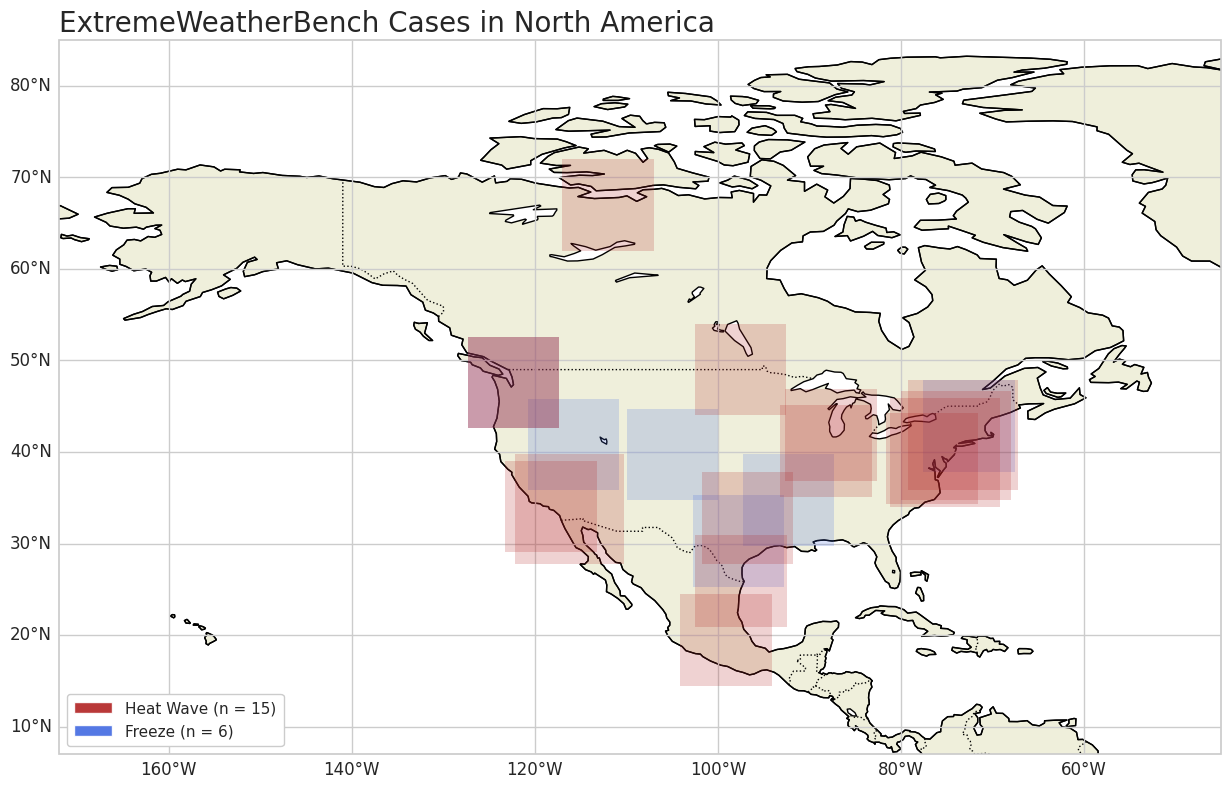

In [5]:
# plot North America
bot_lat = 7
top_lat = 85
left_lon = -172
right_lon = -45
filename = 'extreme_weather_cases_NA.png'
plot_title = 'ExtremeWeatherBench Cases in North America'

plot_local_cases(left_lon, right_lon, bot_lat, top_lat, filename, plot_title)

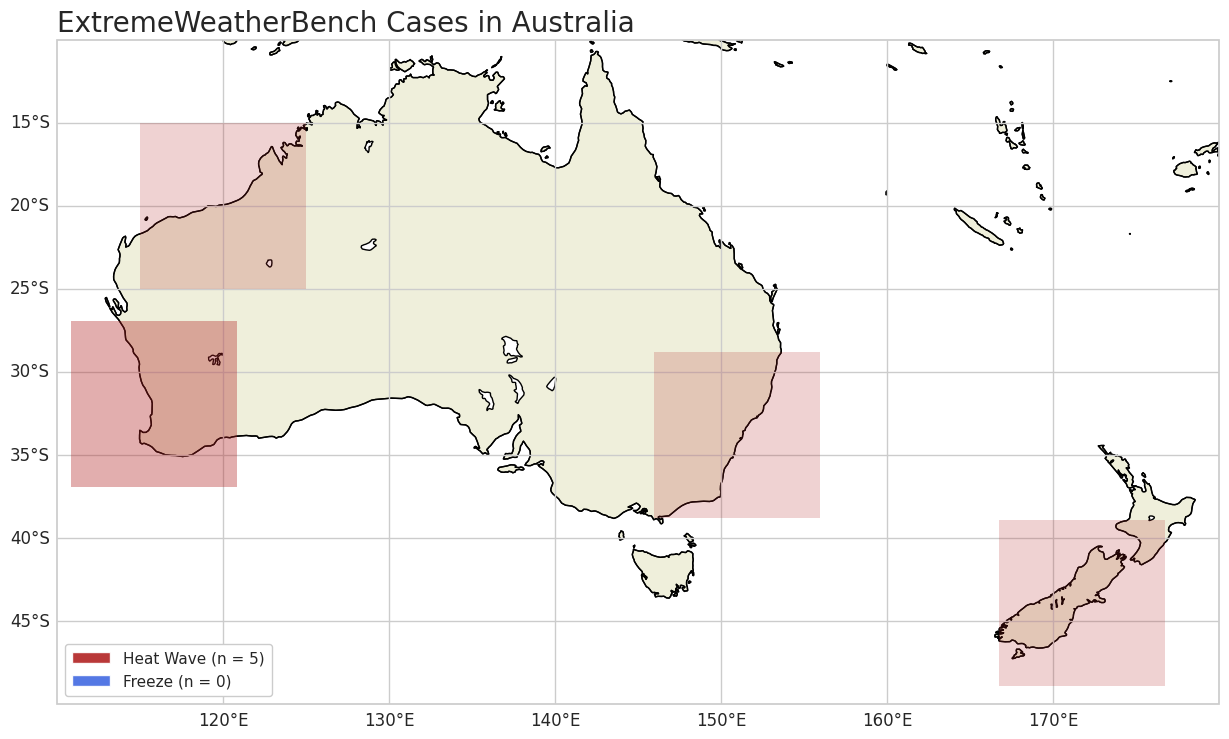

In [6]:
# plot Australia
bot_lat = -50
top_lat = -10
left_lon = 110
right_lon = 180
filename = 'extreme_weather_cases_Aus.png'
plot_title = 'ExtremeWeatherBench Cases in Australia'

plot_local_cases(left_lon, right_lon, bot_lat, top_lat, filename, plot_title)

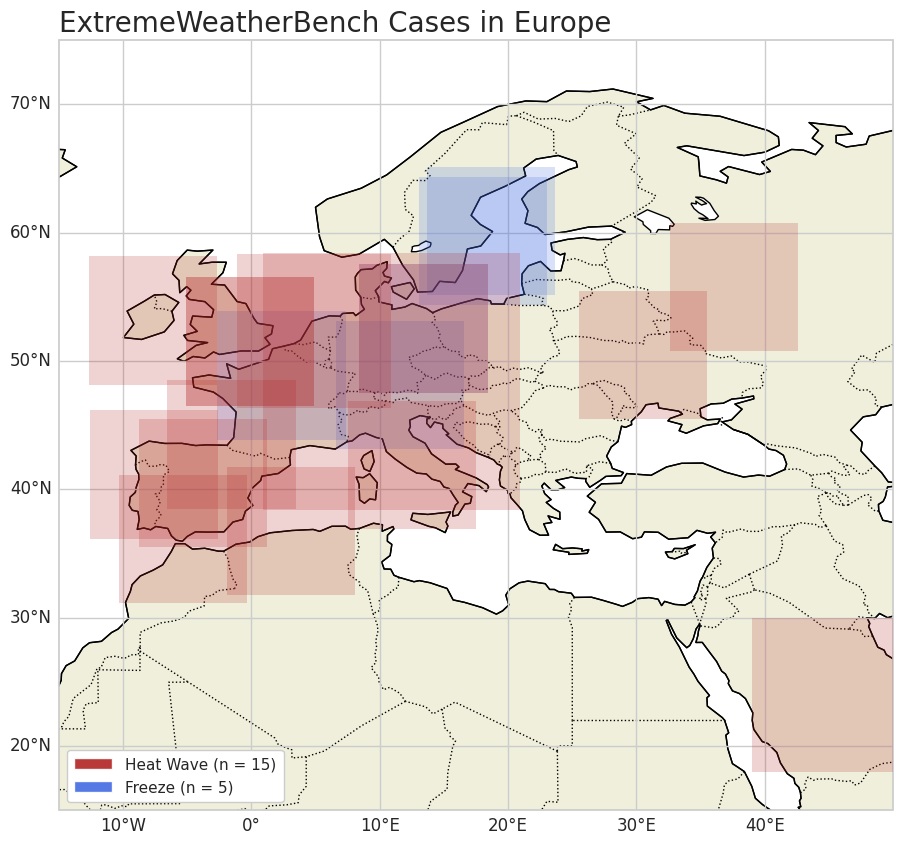

In [7]:
# plot Europe
bot_lat = 15
top_lat = 75
left_lon = -15
right_lon = 50
filename = 'extreme_weather_cases_Europe.png'
plot_title = 'ExtremeWeatherBench Cases in Europe'
plot_local_cases(left_lon, right_lon, bot_lat, top_lat, filename, plot_title)
